<a href="https://colab.research.google.com/github/huhji/NLP-Basic/blob/main/CommonLit_NLP_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common Lit: Detailed Guide to Learn NLP

## Library Importations

In [ ]:
!pip install -U scikit-learn
!python3 -m spacy download en_core_web_lg

In [ ]:
import gc
gc.collect()

111

In [ ]:
import numpy as np
import pandas as pd
import time
import string
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, TweedieRegressor, HuberRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error as mse

import xgboost as xgb

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.io import curdoc, show, output_notebook
output_notebook()

import nltk
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')

import spacy
nlp = spacy.load('en_core_web_lg')
from spacy import displacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Loading Datasets

In [ ]:
# 로컬 파일에서 업로드
from google.colab import files
files.upload()

In [3]:
# Google Drive에서 업로드
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
import os
#os.getcwd()
data_path = "./gdrive/MyDrive/Kaggle_CommonLit"

In [ ]:
train_data = pd.read_csv(os.path.join(data_path,"train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_sub = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

In [6]:
os.listdir(data_path)

['sample_submission.csv',
 'train.csv',
 'test.csv',
 'cleaned_train.csv',
 'cleaned_test.csv']

In [7]:
# load preprocessed data
import pandas as pd
train_data = pd.read_csv(os.path.join(data_path, "cleaned_train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "cleaned_test.csv"))

In [8]:
print("Train dataset shape : ", train_data.shape)
print("Test dataset shape : ", test_data.shape)

Train dataset shape :  (2834, 9)
Test dataset shape :  (7, 5)


In [ ]:
train_data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [ ]:
train_data["excerpt"][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [ ]:
test_data.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


## Exploratory Data Analysis 

In [ ]:
# 결측치 확인
train_data.isnull().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

In [ ]:
test_data.isnull().sum()

id           0
url_legal    4
license      4
excerpt      0
dtype: int64

In [ ]:
# Train Target 가장 큰값 5개 확인
display(train_data.sort_values(by=["target"], ascending=False).head())

,id,url_legal,license,excerpt,target,standard_error
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
981,849971671,https://www.africanstorybook.org/,CC BY 4.0,"For her last birthday, Sisanda had a special t...",1.597870,0.596349
808,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776
1014,7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,More people came to the bus stop just before 9...,1.541672,0.606997
1066,016913371,https://www.africanstorybook.org/,CC BY 4.0,Grandma's garden was wonderful. It was full of...,1.467665,0.599600


In [ ]:
# Train Target 가장 작은값 5개 확인
display(train_data.sort_values(by=["target"]).head())

,id,url_legal,license,excerpt,target,standard_error
1705,4626100d8,NaN,NaN,"The commutator is peculiar, consisting of only...",-3.676268,0.623621
1128,493b80aa7,NaN,NaN,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404
1754,fe44cbd14,NaN,NaN,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398
1752,284eaa5ad,NaN,NaN,As to surface-slope its measurement—from nearl...,-3.639936,0.603819
1720,9e9eacb49,NaN,NaN,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


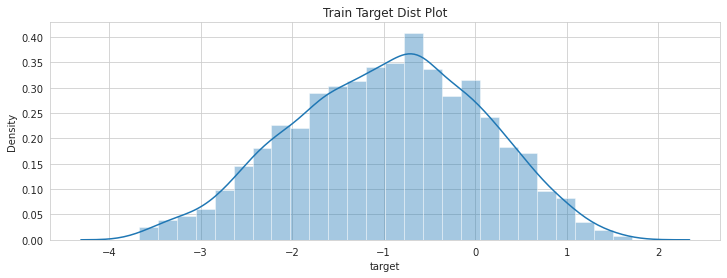

In [ ]:
# Target 분포 확인 

sns.set_style("whitegrid")
plt.figure(figsize=(12,4))
plt.title("Train Target Dist Plot")
sns.distplot(train_data["target"])

Text(0, 0.5, 'Missing Values Percentage')

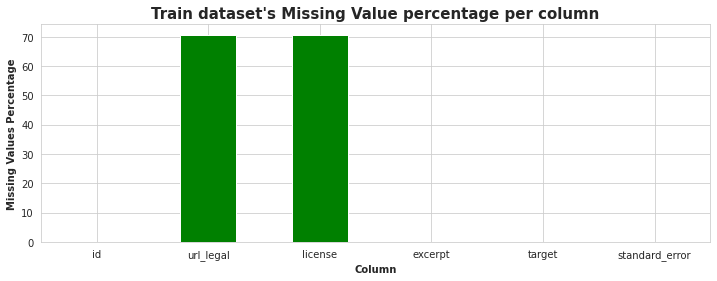

In [ ]:
# 결측치 확인

sns.set_style("whitegrid")
plt.figure(figsize=(12,4))
null_percent = train_data.isnull().mean() * 100
null_percent.plot.bar(color = "green")
plt.title("Train dataset's Missing Value percentage per column", fontsize=15, weight="bold")
plt.xlabel("Column", weight="bold")
plt.xticks(rotation=0)
plt.ylabel("Missing Values Percentage", weight="bold")

Text(0, 0.5, 'Missing Values Percentage')

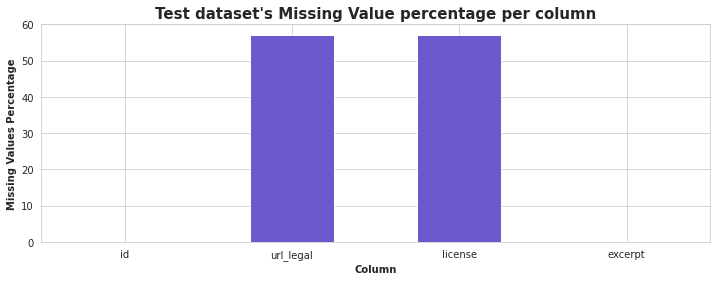

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,4))
test_null_percent = test_data.isnull().mean() * 100
test_null_percent.plot.bar(color = "slateblue")
plt.title("Test dataset's Missing Value percentage per column", fontsize=15, weight="bold")
plt.xlabel("Column", weight="bold")
plt.xticks(rotation=0)
plt.ylabel("Missing Values Percentage", weight="bold")

Text(0.5, 1.0, "Train data's exceprt word count KDE plot")

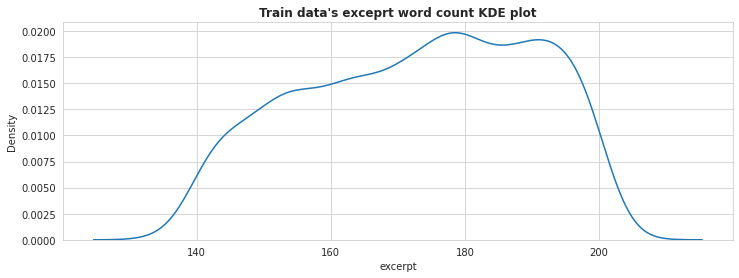

In [ ]:
# 발췌문(excerpt) 단어 개수와 길이 확인

plt.figure(figsize=(12, 4))
sns.kdeplot(train_data["excerpt"].str.split().str.len())
plt.title("Train data's exceprt word count KDE plot", weight="bold")

Text(0.5, 1.0, "Train data's excerpt length KDE plot")

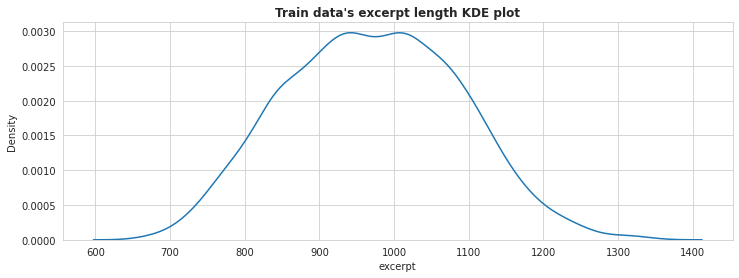

In [ ]:
plt.figure(figsize=(12,4))
sns.kdeplot(train_data["excerpt"].str.len())
plt.title("Train data's excerpt length KDE plot", weight="bold")

Text(0.5, 1.0, "Train data's License Distribution")

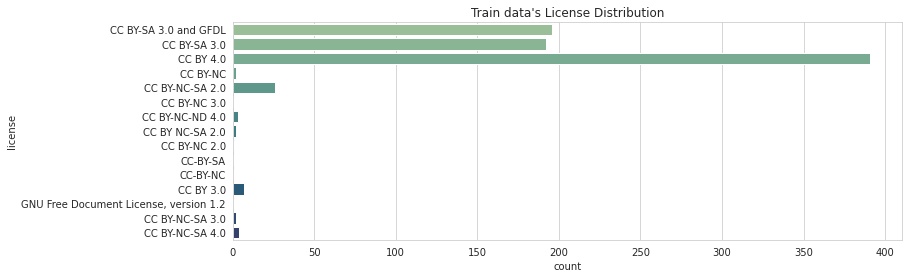

In [ ]:
# License 분포 확인
plt.figure(figsize=(12,4))
sns.countplot(y="license", data=train_data, palette="crest")
plt.title("Train data's License Distribution")

In [ ]:
# collections의 Counter 함수를 사용한 전체 단어 개수 구하기

word_count = Counter()
train_data["excerpt"].str.lower().str.split().apply(word_count.update)
print("Unique Whole Word : ", len(word_count.keys()))

Unique Whole Word :  51038


In [ ]:
# 가장 긴 단어와 가장 짧은 단어 확인
longest_word = max(word_count.keys(), key=len)
print("Longest word : ", longest_word)
print("Length of Longest word : ", len(longest_word), "\n")

shortest_word = min(word_count.keys(), key=len)
print("Shortest word : ", shortest_word)
print("Length of Shortest word : ", len(shortest_word))

Longest word :  doi:10.1016/j.iheduc.2008.03.001
Length of Longest word :  32 

Shortest word :  a
Length of Shortest word :  1


In [ ]:
sorted_word = sorted(word_count.keys(), key=len)
print("5 Longest words : ", sorted_word[-5:])
print("5 Shortest words : ", sorted_word[:5])

5 Longest words :  ['storing/retrieval/processing', 'polyhedron(pol-ee-hee-dron).', 'doi:10.1016/j.iheduc.2008.03.001', 'scream—whew-ew-ew-ew-bang!—broke', 'hundred—going—going—going—gone!"']
5 Shortest words :  ['a', 'i', '—', 'o', '5']


In [ ]:
# Target 점수가 가장 낮은 excerpt 확인 (readibility score가 낮을수록 읽기 어려운 문장)
train_data.head()
hardest_excerpt = train_data.loc[train_data["target"] == train_data["target"].min()].excerpt
list(hardest_excerpt)

['The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted 

In [ ]:
# Target 점수가 가장 높은 excerpt 확인 (가장 읽기 쉬운 문장)
easiest_excerpt = train_data.loc[train_data["target"] == train_data["target"].max()].excerpt
list(easiest_excerpt)

['When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?\nThis surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.\nOne of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.']

## Data Preprocessing

### Data Cleaning

In [ ]:
# stop word 제거
def removeStopwords(text):
    document = nlp(text)
    clean_text = ' '
    for txt in document:
        if (txt.is_stop == False):
            clean_text += " " + str(txt)        
    return clean_text

print("\033[1mText before removeStopwords function: \033[0m" + train_data['excerpt'][1] + "\n")
print("\033[1mText after removeStopwords function: \033[0m" + removeStopwords(train_data['excerpt'][1]))

Text before removeStopwords function: All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.
At last, however, when the meal was nearly over, she smiled at her little daughter, and said, "All right, Dolly, you may go."
"Oh, mother!" Dolly cried, overwhelmed with sudden delight. "Really?
Oh, I am so glad! Are you sure you're willing?"
"I've persuaded myself to be willing, against my will," returned Mrs. Fayre, whimsically. "I confess I just hate to have you go, but I can't bear to deprive you of the pleasure trip. And, as you say, it would also keep Dotty at home, and so, altogether, I think I shall have to give in."
"Oh, you angel mother! You blessed lady! How good you are!" And Dolly flew around the table and gave her mother a hug that nearly suffocated her.

Text after removeStopwo

In [ ]:
# 문장기호 제거(. , ! ? " ')
def removePunctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

print("\033[1mText before removePunctuations function: \033[0m" + train_data['excerpt'][1] + "\n")
print("\033[1mText after removePunctuations function: \033[0m" + removePunctuations(train_data['excerpt'][1]))

Text before removePunctuations function: All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.
At last, however, when the meal was nearly over, she smiled at her little daughter, and said, "All right, Dolly, you may go."
"Oh, mother!" Dolly cried, overwhelmed with sudden delight. "Really?
Oh, I am so glad! Are you sure you're willing?"
"I've persuaded myself to be willing, against my will," returned Mrs. Fayre, whimsically. "I confess I just hate to have you go, but I can't bear to deprive you of the pleasure trip. And, as you say, it would also keep Dotty at home, and so, altogether, I think I shall have to give in."
"Oh, you angel mother! You blessed lady! How good you are!" And Dolly flew around the table and gave her mother a hug that nearly suffocated her.

Text after removePun

thinking...

* 문장기호와 readibility score와의 관계? 문장기호가 더 많으면 상대적으로 읽기 쉬운 문장이지 않을까?
* 문장 길이/문자 길이와 score의 관계? 문장 길이가 길수록 읽기 힘드니까, 긴 글자도 마찬가지 (안녕! vs 안녕하셨습니까)
* 

In [ ]:
# 링크 주소 제거
def removeLinks(text):
    clean_text = re.sub('https?://\S+|www\.\S+', '', text)
    return clean_text

test_string = "http://www.youtube.com/ and https://www.youtube.com/ should be removed "
(test_string,removeLinks(test_string))

('http://www.youtube.com/ and https://www.youtube.com/ should be removed ',
 ' and  should be removed ')

In [ ]:
# 숫자 제거
def removeNumbers(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

test_string = "Hi 🙈 99 girls are running"
(test_string,removeNumbers(test_string))

('Hi 🙈 99 girls are running', 'Hi 🙈  girls are running')

In [ ]:
# 함수 하나로 통합
def clean(text):
    text = text.lower() #Lets make it lowercase
    text = removeStopwords(text)
    text = removePunctuations(text)
    text = removeNumbers(text)
    text = removeLinks(text)
    return text

In [ ]:
# train 데이터에 정보 추가

train_data['excerpt_len'] = train_data['excerpt'].apply(
    lambda x : len(x)
)
train_data['excerpt_word_count'] = train_data['excerpt'].apply(
    lambda x : len(x.split(' '))
)
train_data['excerpt_clean'] = train_data['excerpt'].apply(clean)
train_data.head()

,id,url_legal,license,excerpt,target,standard_error,excerpt_len,excerpt_word_count,excerpt_clean
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,992,174,young people returned ballroom presented de...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,937,164,dinner time mrs fayre somewhat silent eye...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,908,162,roger predicted snow departed quickly came ...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,909,163,outside palace great garden walled round fi...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,723,147,time bears lived house wood little small ...


In [ ]:
# test 데이터에도 똑같이 적용 
test_data['excerpt_clean'] = test_data['excerpt'].apply(clean)
test_data.head()

,id,url_legal,license,excerpt,excerpt_clean
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...,hope lay jack promise bright light burning u...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...,dotty continued mrs gray night milk katie ...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...,bright cheerful scene greeted eyes captain r...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...,cell division process parent cell divides da...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...,debugging process finding resolving defects ...


In [ ]:
train_data.to_csv(os.path.join(data_path, "cleaned_train.csv"), index=False)
test_data.to_csv(os.path.join(data_path, "cleaned_test.csv"), index=False)

In [ ]:
# cleaning 된 excerpt의 단어 개수 확인
results = Counter()
train_data['excerpt_clean'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

26154


In [ ]:
train_data.excerpt_clean

0         young people returned ballroom  presented de...
1         dinner time  mrs  fayre somewhat silent  eye...
2         roger predicted  snow departed quickly came ...
3         outside palace great garden walled round  fi...
4         time bears lived house wood  little  small  ...
                              ...                        
2829      think dinosaurs lived  picture  hot  steamy ...
2830      solid  solids usually hard molecules packed ...
2831      second state matter discuss liquid  solids h...
2832      solids shapes actually touch  dimensions  me...
2833      animals cells  eat things digest inside  ani...
Name: excerpt_clean, Length: 2834, dtype: object

### N-gram preprocessing

In [ ]:
# sklearn의 CountVectorizer를 사용해 단어 빈도수 구하기 (Unigram)

vec = CountVectorizer().fit(train_data['excerpt_clean'])
bag_of_words = vec.transform(train_data['excerpt_clean'])
sum_words = bag_of_words.sum(axis=0) # sum_words: (1, 26040) matrix

In [ ]:
# train dataset의 전체 단어 빈도수 상위 10개 출력

words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
freq_sorted[:10]

[('little', 1137),
 ('said', 1112),
 ('time', 919),
 ('like', 837),
 ('people', 750),
 ('great', 702),
 ('water', 672),
 ('day', 662),
 ('called', 647),
 ('old', 625)]

In [ ]:
# sklearn의 CountVectorizer를 사용해 Bi-gram 빈도수 구하기 

vec_bigram = CountVectorizer(ngram_range = (2,2)).fit(train_data['excerpt_clean']) # bigram
bag_of_bigram = vec_bigram.transform(train_data['excerpt_clean'])
sum_bigram = bag_of_bigram.sum(axis=0) # sum_bigram: (1, 192993) matrix

In [ ]:
# unigram --> bigram으로 바뀌며 Ngram 개수 변화
np.shape(sum_bigram)

(1, 192993)

In [ ]:
# bigram 빈도수 상위 10개 출력 
bigram_freq = [(word, sum_bigram[0, idx]) for word, idx in vec_bigram.vocabulary_.items()]
bigram_freq_sorted = sorted(bigram_freq, key = lambda x: x[1], reverse=True)
bigram_freq_sorted[:10]

[('united states', 100),
 ('years ago', 77),
 ('years old', 58),
 ('long time', 58),
 ('little girl', 56),
 ('th century', 55),
 ('old man', 49),
 ('new york', 46),
 ('little boy', 44),
 ('carbon dioxide', 38)]

In [ ]:
# Top N개 Unigram, Bigram 빈도수 구하는 함수
def get_top_n_words(corpus, n = None):
    """
    A function that returns the top 'n' unigrams used in the corpus
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus) 
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return freq_sorted[:n]

def get_top_n_bigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

In [ ]:
top_unigram = get_top_n_words(train_data['excerpt_clean'], 20)
words = [i[0] for i in top_unigram]
count = [i[1] for i in top_unigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#6baed6'] * 20))

p = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Unigrams", tools = "hover", tooltips = "@Word: @counts")
p.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
curdoc().theme = 'dark_minimal'
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.title.align = 'center'
p.xaxis.major_label_orientation = "vertical"
show(p)

In [ ]:
top_bigram = get_top_n_bigram(train_data['excerpt_clean'], 20)
words = [i[0] for i in top_bigram]
count = [i[1] for i in top_bigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#a1dab4'] * 20))

p1 = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Bigrams", tools = "hover", tooltips = "@Word: @counts")
p1.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
# curdoc().theme = 'dark_minimal'
p1.xgrid.grid_line_color = None
p1.title.align = 'center'
p1.y_range.start = 0
p1.xaxis.major_label_orientation = "vertical"
show(p1)

### Stemming

Stemming : 어간 추출
* Stemming은 정해진 규칙만 보고 단어의 어미를 자르는 어림짐작의 작업입니다.  
* 섬세한 작업이 아닌 룰베이스에 기반한 작업이기 때문에, 어간 추출 후에 나오는 결과 단어는 사전에 존재하지 않는 단어일 수도 있습니다.
* NLTK의 Stemmer에는 Porter Stemmer 와 Snowball stemmer가 있는데, Snowball stemmer가 Porter보다 살짝 높은 버전이고, 보다 많이 사용되는 Stemmer이기 때문에 이번 전처리 작업에서는 Snowball을 사용했습니다.
* Stemming과 Lemmatization은 둘 다 변형된 단어를 원래 형태로 바꿔줍니다. 차이점은, Stemming은 속도가 빠르나 간혹 존재하지 않는 단어가 나올 수 있고, Lemmatization은 실제 단어 원형을 가져온다는 점입니다.



In [ ]:
stemmer = SnowballStemmer(language='english')

tokens = train_data['excerpt'][1].split()
clean_text = ' '

for token in tokens[:20]:
    print(token + ' --> ' + stemmer.stem(token))

All --> all
through --> through
dinner --> dinner
time, --> time,
Mrs. --> mrs.
Fayre --> fayr
was --> was
somewhat --> somewhat
silent, --> silent,
her --> her
eyes --> eye
resting --> rest
on --> on
Dolly --> dolli
with --> with
a --> a
wistful, --> wistful,
uncertain --> uncertain
expression. --> expression.
She --> she


In [ ]:
def stemWord(text):
    stemmer = SnowballStemmer(language='english')
    tokens = text.split()
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + stemmer.stem(token)      
    
    return clean_text

print("\033[1mText before stemWord function: \033[0m" + train_data['excerpt'][1] + "\n")
print("\033[1mText after stemWord function: \033[0m" + stemWord(train_data['excerpt'][1]))

Text before stemWord function: All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.
At last, however, when the meal was nearly over, she smiled at her little daughter, and said, "All right, Dolly, you may go."
"Oh, mother!" Dolly cried, overwhelmed with sudden delight. "Really?
Oh, I am so glad! Are you sure you're willing?"
"I've persuaded myself to be willing, against my will," returned Mrs. Fayre, whimsically. "I confess I just hate to have you go, but I can't bear to deprive you of the pleasure trip. And, as you say, it would also keep Dotty at home, and so, altogether, I think I shall have to give in."
"Oh, you angel mother! You blessed lady! How good you are!" And Dolly flew around the table and gave her mother a hug that nearly suffocated her.

Text after stemWord function: 

In [ ]:
train_data['excerpt_clean'] = train_data['excerpt_clean'].apply(stemWord)
test_data['excerpt_clean'] = test_data['excerpt_clean'].apply(stemWord)

In [ ]:
train_data.to_csv(os.path.join(data_path, "cleaned_train.csv"), index=False)
test_data.to_csv(os.path.join(data_path, "cleaned_test.csv"), index=False)

In [ ]:
results = Counter()
train_data['excerpt_clean'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

16539


### Lemmatization

In [ ]:
# Lemmatization: 표제어 추출

oc = nlp("Apple is looking at buying U.K. startup for $1 billion")
#for token in doc:
   # print(token.lemma_)
for noun in doc.noun_chunks:
    print(noun.text)

Apple
U.K. startup


In [ ]:
# origin text vs after lemma
for word in doc:
    print(word.text, word.lemma_)

Apple Apple
is be
looking look
at at
buying buy
U.K. U.K.
startup startup
for for
$ $
1 1
billion billion


In [ ]:
# 원본 발췌문과 표제어 변환 후 비교
def lemmatizeWord(text):
    tokens=nlp(text)
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + token.lemma_      
    
    return clean_text

print("Text before lemmatizeWord function: " + train_data['excerpt'][1] + "\n")
print("Text after lemmatizeWord function: " + lemmatizeWord(train_data['excerpt'][1]))

doc = "Apple is looking at buying U.K. startup for $1 billion"
lemmatizeWord(doc)

Text before lemmatizeWord function: All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.
At last, however, when the meal was nearly over, she smiled at her little daughter, and said, "All right, Dolly, you may go."
"Oh, mother!" Dolly cried, overwhelmed with sudden delight. "Really?
Oh, I am so glad! Are you sure you're willing?"
"I've persuaded myself to be willing, against my will," returned Mrs. Fayre, whimsically. "I confess I just hate to have you go, but I can't bear to deprive you of the pleasure trip. And, as you say, it would also keep Dotty at home, and so, altogether, I think I shall have to give in."
"Oh, you angel mother! You blessed lady! How good you are!" And Dolly flew around the table and gave her mother a hug that nearly suffocated her.

Text after lemmatizeWord 

'  Apple be look at buy U.K. startup for $ 1 billion'

### Part-Of-Speech Tagging

POS 태그는 단어의 정의와 맥락을 기반으로 말뭉치에 명사, 동사, 형용사 등의 명칭을 태그하는 방법이다.

In [ ]:
# 전처리된 excerpt_clean에 pos_tag 라이브러리 매핑하기

train_data['pos_tags'] = train_data['excerpt_clean'].str.split().map(pos_tag)

In [ ]:
train_data['pos_tags']

0       [(young, JJ), (peopl, VBP), (return, NN), (bal...
1       [(dinner, NN), (time, NN), (mrs, JJ), (fayr, N...
2       [(roger, NN), (predict, NN), (snow, VBP), (dep...
3       [(outsid, NN), (palac, NN), (great, JJ), (gard...
4       [(time, NN), (bear, JJ), (live, VBP), (hous, J...
                              ...                        
2829    [(think, VB), (dinosaur, NNS), (live, VBP), (p...
2830    [(solid, JJ), (solid, JJ), (usual, JJ), (hard,...
2831    [(second, JJ), (state, NN), (matter, NN), (dis...
2832    [(solid, JJ), (shape, NN), (actual, JJ), (touc...
2833    [(anim, NN), (cell, NN), (eat, JJ), (thing, NN...
Name: pos_tags, Length: 2834, dtype: object

In [ ]:
# 학습 데이터에 POS 태깅 컬럼 추가
def count_tags(pos_tags):
    tag_count = {}
    for word,tag in pos_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return tag_count

train_data['tag_counts'] = train_data['pos_tags'].map(count_tags)

In [ ]:
train_data['tag_counts']

0       {'JJ': 27, 'VBP': 3, 'NN': 46, 'RB': 1, 'VBD':...
1       {'NN': 37, 'JJ': 13, 'RB': 2, 'VBP': 5, 'NNS':...
2       {'NN': 40, 'VBP': 4, 'JJ': 16, 'VBD': 2, 'IN':...
3       {'NN': 54, 'JJ': 17, 'VBP': 3, 'IN': 3, 'RB': ...
4       {'NN': 32, 'JJ': 26, 'VBP': 5, 'NNS': 2, 'IN':...
                              ...                        
2829    {'VB': 2, 'NNS': 4, 'VBP': 6, 'NN': 36, 'JJ': ...
2830    {'JJ': 19, 'NN': 37, 'RBR': 1, 'VBP': 4, 'IN':...
2831    {'JJ': 15, 'NN': 45, 'VB': 2, 'VBD': 2, 'VBP':...
2832    {'JJ': 17, 'NN': 44, 'NNS': 2, 'VBP': 3, 'VBD'...
2833    {'NN': 46, 'JJ': 16, 'JJS': 1, 'VBD': 3, 'IN':...
Name: tag_counts, Length: 2834, dtype: object

In [ ]:
# 각 품사 태그 컬럼 생성, 빈도수 추가

set_pos = set([tag for tags in train_data['tag_counts'] for tag in tags])
tag_cols = list(set_pos)

for tag in tag_cols:
    train_data[tag] = train_data['tag_counts'].map(lambda x: x.get(tag, 0))

In [ ]:
# tagging된 데이터 확인
train_data.loc[0]

id                                                            c12129c31
url_legal                                                           NaN
license                                                             NaN
excerpt               When the young people returned to the ballroom...
target                                                        -0.340259
standard_error                                                 0.464009
excerpt_len                                                         992
excerpt_word_count                                                  174
excerpt_clean           young peopl return ballroom present decid ch...
pos_tags              [(young, JJ), (peopl, VBP), (return, NN), (bal...
tag_counts            {'JJ': 27, 'VBP': 3, 'NN': 46, 'RB': 1, 'VBD':...
JJ                                                                   27
PDT                                                                   0
JJS                                                             

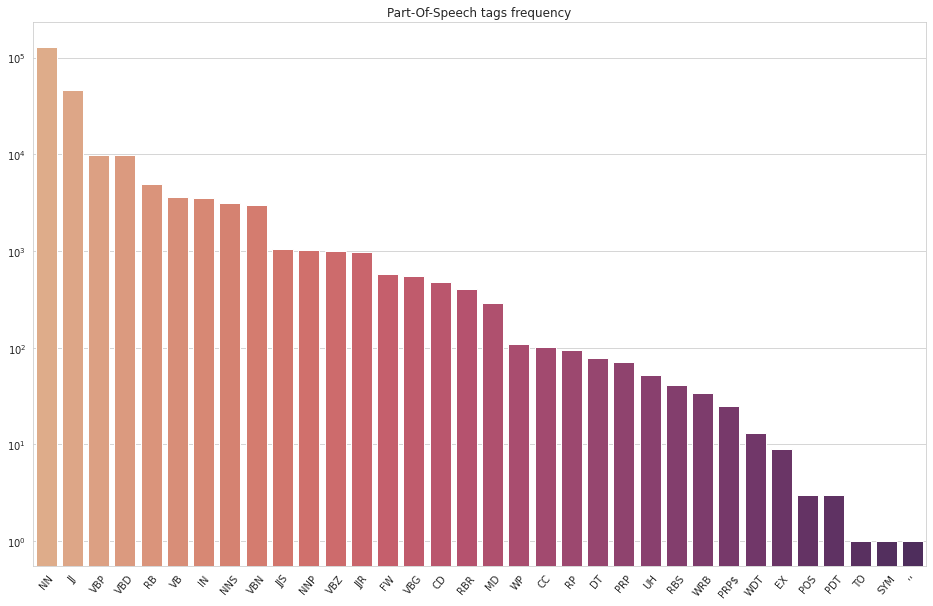

In [ ]:
# POS 빈도 그래프
pos = train_data[tag_cols].sum().sort_values(ascending = False)
sns.set_style("whitegrid")
plt.figure(figsize=(16,10))
ax = sns.barplot(x=pos.index, y=pos.values,palette="flare")
plt.xticks(rotation = 50)
ax.set_yscale('log')
plt.title('Part-Of-Speech tags frequency')
plt.show()

In [ ]:
train_data.loc[train_data['target'] == train_data['target'].max()].excerpt.to_string()

'2829    When you think of dinosaurs and where they liv...'

In [ ]:
# target 점수가 가장 높은(가장 읽기 쉬운) 발췌문으로 품사 태깅 확인하기
sent = str()
for word in train_data.loc[train_data['target'] == train_data['target'].max()].excerpt:
    sent += word

In [ ]:
sent

'When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?\nThis surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.\nOne of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.'

In [ ]:
doc1 = nlp(sent)

In [ ]:
# 단어들간의 관계와 품사 시각화
displacy.render(doc1, style="dep", jupyter="True")

### Named Entity Recognition

**spaCy** 는 자연어를 처리하는 매우 빠른 통계 기반 라이브러리이다.

회사, 장소, 조직, 제품 등의 고유명사를 식별하여 태깅할 수 있다. 통계 기반 프로세스이기 때문에 학습된 데이터에 따라 식별하는 정도가 달라질 수 있으며 필요한 경우 튜닝도 가능하다.

spaCy에 의해 명명된 단어는 문서의 ents 속성으로 사용한다.

In [ ]:
doc1 = nlp(train_data['excerpt'][22]);doc1

Were you ever on the coast of Maine? If so, you know how the rocky shores stretch out now and then clear into the ocean, and fret the salt waves till they are all in a foam. Old Ocean is not to be so set at defiance and have his rightful territory wrung from him, without taking his revenge after his own fashion. Far up into the land he sends his arms, and crooks and bends and makes his way amid the rocks, and finally falls asleep in some quiet harbor, where the tall pines stand by the shore to sing him a lullaby.
In just such a spot as this the town we shall call Fairport was built. Axe in one hand and Bible in the other, stern settlers here found a home. Strong hard-featured sons, and fair rosy-cheeked daughters made glad the rude cabins that were soon scattered along the shore. The axe was plied in the woods, and the needle by the fireside, and yet grim Poverty was ever shaking her fist in the very faces of the settlers, and whispering sad things of what the uncertain future might ha

In [ ]:
# doc1에 속한 ents(Entity) 단어 확인
doc1.ents

(Maine, Ocean, Fairport, Bible)

In [ ]:
# spacy를 사용하여 고유명사 태깅하기

displacy.render(doc1, style="ent", jupyter="True")
# gpe = Geopolitical Entity
# org = Organization

In [ ]:
for e in doc1.ents:
  print(e.text, e.start_char, e.end_char, e.label_)

Maine 30 35 GPE
Ocean 178 183 LOC
Fairport 570 578 ORG
Bible 610 615 WORK_OF_ART


## Bag of Words + Model

Bag of Words는 문서 내 단어의 발생 빈도를 표현하는 방식. BoW를 만드는 과정은 다음과 같다.
1. 문장의 각 단어에 고유한 인덱스를 부여한다.
2. 각 인덱스의 단어에 해당 단어의 출현 횟수를 기록한 벡터를 생성한다.

In [ ]:
# Define Root Mean Squred Error
rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))
rmse_loss = lambda Estimator, X, y: rmse(y, Estimator.predict(X))

# Split data into Train and Test sets
x = train_data['excerpt_clean']
y = train_data['target']

print(len(x), len(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

2834 2834
2125 2125
709 709


### Linear Regression

In [ ]:
# Unigram only
# CountVectorizer(...ngram_range=(min_n, max_n))
# only unigram: (1,1)
# unigram & bigram: (1,2)
# only bigram: (2,2)

# 단어에 대한 빈도수를 이용하여 Target 점수 선형회귀 계산

model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)), # unigram only
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(1,1): {val_score}')

Train Score for CountVectorizer(1,1): 0.9262068130921135


In [ ]:
# Bi-grams only

model = make_pipeline(
    CountVectorizer(ngram_range=(2,2)), # Bigram only
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(2,2): {val_score}')

Train Score for CountVectorizer(2,2): 0.9869933820566695


In [ ]:
# Unigram + Bigram

model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)), # Unigram + Bigram
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(1,2): {val_score}')

Train Score for CountVectorizer(1,2): 0.8056790248654074


In [ ]:
model

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('linearregression', LinearRegression())])

In [ ]:
# Unigram + Bigram + Trigram

model = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(1,3): {val_score}')

Train Score for CountVectorizer(1,3): 0.80029988147739


### Ridge Regression

In [ ]:
# Ridge Regression with Unigram

model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    Ridge(),
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for Ridge Regression: {val_score}')

Train Score for Ridge Regression: 0.9171236575608557


In [ ]:
# Ridge Regression with Unigram + Bigram + Trigram

model = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),
    Ridge(),
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for Ridge Regression: {val_score}')

Train Score for Ridge Regression: 0.800328631450076


### Extreme Gradient Boosting

In [ ]:
# xgb with Unigram

model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    xgb.XGBRegressor() ,
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for Extreme Gradient Boosting: {val_score}')

[03:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Score for Extreme Gradient Boosting: 0.8917063633326539


In [ ]:
# xgb with Unigram + Bigram

model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    xgb.XGBRegressor() ,
)

val_score = cross_val_score(
    model, 
    train_data['excerpt_clean'], 
    train_data['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for Extreme Gradient Boosting: {val_score}')

[03:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:52:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:52:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:52:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Score for Extreme Gradient Boosting: 0.8924020415154391


## TF-IDF + Model

In [79]:
# TF-IDF 적용
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(train_data['excerpt_clean'])
tfidf_train = vectorizer.transform(train_data['excerpt_clean'])

In [80]:
# TF-IDF 적용 후 데이터 형태 
tfidf_train.shape # (단어 수, 발췌문 수)

(2834, 16569)

In [81]:
# Row: excerpt, Col: word
pd.DataFrame(tfidf_train.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16529,16530,16531,16532,16533,16534,16535,16536,16537,16538,16539,16540,16541,16542,16543,16544,16545,16546,16547,16548,16549,16550,16551,16552,16553,16554,16555,16556,16557,16558,16559,16560,16561,16562,16563,16564,16565,16566,16567,16568
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Linear Regression 적용
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
torch.FloatTensor([[1], [2], [3]])

tensor([[1.],
        [2.],
        [3.]])

In [50]:
x_train = torch.FloatTensor(tfidf_train.toarray())
y_train = torch.FloatTensor(train_data['target'])

In [46]:
y_train

tensor([-0.3403, -0.3154, -0.5801,  ...,  0.2552, -0.2153,  0.3008])

In [28]:
x_train.shape

torch.Size([2834, 16569])

In [51]:
y_train = torch.reshape(y_train, (2834,1)) 
y_train.shape

torch.Size([2834, 1])

기본적으로 pyTorch는 NCHW형태로 데이터를 입력받는다.

NVIDIA 또한 GPU Accelerator의 최적 입력값으로 NCHW 형식을 사용한다. 최적의 성능을 위해서는 NCHW 형태로 변환하는 것을 권장한다.

In [72]:
# 다중 회귀 모델 정의

class MultivariateLinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(16569,1) # 다항 개수 

  def forward(self, x):
    return self.linear(x)

In [73]:
torch.manual_seed(42)
model = MultivariateLinearRegression()

In [74]:
hypothesis = model(x_train)

In [75]:
print(hypothesis.shape)
print(y_train.shape)

torch.Size([2834, 1])
torch.Size([2834, 1])


In [76]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [77]:
y_train

tensor([[-0.3403],
        [-0.3154],
        [-0.5801],
        ...,
        [ 0.2552],
        [-0.2153],
        [ 0.3008]])

In [61]:
# RMSE loss function 정의
class RMSELoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()

  def forward(self, y_hat, y):
    return torch.sqrt(self.mse(y_hat, y))

In [78]:
epochs = 1000
hypothesis = model(x_train)
rmse_loss = RMSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(epochs+1):

  prediction = model(x_train)
  cost = rmse_loss(prediction, y_train)

  optimizer.zero_grad()
  cost.backward(retain_graph=True)
  optimizer.step()

  if epoch%100 == 0:
    print(f"Epoch: {epoch}/{epochs}  Cost: {cost.item()}")

Epoch: 0/1000  Cost: 1.415529489517212
Epoch: 100/1000  Cost: 1.3699359893798828
Epoch: 200/1000  Cost: 1.3280140161514282
Epoch: 300/1000  Cost: 1.289779543876648
Epoch: 400/1000  Cost: 1.2551976442337036
Epoch: 500/1000  Cost: 1.2241817712783813
Epoch: 600/1000  Cost: 1.1965950727462769
Epoch: 700/1000  Cost: 1.1722571849822998
Epoch: 800/1000  Cost: 1.150951862335205
Epoch: 900/1000  Cost: 1.1324365139007568
Epoch: 1000/1000  Cost: 1.1164535284042358


In [ ]:
# TF-IDF + 여러 model 함수 작성

def training(model, X_train, y_train, X_test, y_test, model_name, ngram_range):
    t1 = time.time()
    
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=ngram_range),
        model,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = rmse(y_test, y_pred)
    
    t2 = time.time()
    training_time = t2-t1 
    return RMSE, training_time

In [ ]:
# 모델 선언하기
ridge = Ridge(fit_intercept = True, normalize = False)
lr = LinearRegression()
xgbr = xgb.XGBRegressor()
lasso = Lasso(alpha=0.1)
tr = TweedieRegressor()
hr = HuberRegressor(max_iter = 300)
models = [ridge,lr,xgbr,lasso,tr,hr]

modelnames = ["Ridge Regression","Linear Regression","Extreme Gradient Boosting", "Lasso Regression","Tweedie Regressor","Huber Regressor"]

In [ ]:
X = train_data["excerpt_clean"]
y = train_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n_gram_dict = { "Unigram" : (1,1), "Unigrams + Bigrams": (1,2), "Bigrams alone": (2,2), "Unigrams + Bigrams + Trigrams": (1,3)}
rmse_dict = collections.defaultdict(list)
time_dict = collections.defaultdict(list)
for n_gram in n_gram_dict.keys():
    for i in range(0,len(models)):
        result = training(model=models[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=modelnames[i],ngram_range=n_gram_dict[n_gram])
        rmse_dict[n_gram] += [result[0]] 
        time_dict[n_gram] += [result[1]]

In [ ]:
# N-gram & Regression 조합 훈련 결과 테이블(RMSE)
pd.DataFrame.from_dict(rmse_dict, orient='index', columns=modelnames)

,Ridge Regression,Linear Regression,Extreme Gradient Boosting,Lasso Regression,Tweedie Regressor,Huber Regressor
Unigram,0.735756,0.790700,0.840579,1.039898,1.037362,0.785778
Unigrams + Bigrams,0.757662,0.762766,0.954453,1.039898,1.038875,0.762204
Bigrams alone,0.959778,0.910347,1.009035,1.039898,1.039794,0.910826
Unigrams + Bigrams + Trigrams,0.774075,0.791178,0.934292,1.039898,1.039138,0.790582


In [ ]:
# N-gram & Regression 조합 훈련 시간 테이블
pd.DataFrame.from_dict(time_dict, orient='index', columns=modelnames)

,Ridge Regression,Linear Regression,Extreme Gradient Boosting,Lasso Regression,Tweedie Regressor,Huber Regressor
Unigram,0.208725,0.266625,2.578120,0.245677,0.236214,2.534675
Unigrams + Bigrams,0.807815,0.814527,13.700701,1.236704,0.831710,17.717422
Bigrams alone,0.616868,0.664402,11.145128,1.038310,0.654560,15.476595
Unigrams + Bigrams + Trigrams,1.408142,1.535167,25.302221,2.370634,1.622828,35.308658


## Embedding + Model

In [ ]:
!pip install transformers

In [84]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from transformers import (AutoModel,AutoModelForMaskedLM, AutoTokenizer, LineByLineTextDataset,
                         DataCollatorForLanguageModeling,Trainer, TrainingArguments,)

In [85]:
train_data = pd.read_csv(os.path.join(data_path,"train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_sub = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

In [86]:
text  = '.'.join(train_data.excerpt.tolist() + test_data.excerpt.tolist())

with open(os.path.join(data_path,'text.txt'),'w') as f:
    f.write(text)

In [ ]:
model_name = 'roberta-base'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [94]:
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=os.path.join(data_path,'text.txt'), #mention text file here
    block_size=128,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir="./clrp_roberta_base_chk", #select model path
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    eval_steps=20,
    metric_for_best_model = 'eval_loss',
    greater_is_better=False,
    load_best_model_at_end =True,
    prediction_loss_only=True,
    report_to = "none" 
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset)

In [95]:
trainer.train()

Step,Training Loss
500,1.798800


TrainOutput(global_step=804, training_loss=1.7318643218842311, metrics={'train_runtime': 585.8344, 'train_samples_per_second': 1.372, 'total_flos': 1228010344389360.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 0, 'train_mem_gpu_alloc_delta': 1004658176, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 3423351808})

### Simple Embedding

In [ ]:
# ReductLROnPlateau는 모델의 성능이 더이상 나아지지 않을때 callback하는 함수이다.

learning_rate_reduction = ReduceLROnPlateau(monitor='val_root_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
def predict_complexity(model, excerpt):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(excerpt)
  excerpt_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(excerpt_padded)
  for x in range(len(excerpt_padded)):
    print(excerpt[x])
    print(classes[x])
    print('\n')

In [ ]:
text = train_data.excerpt_clean
vocab_size = 51038
embedding_dim = 64
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index

In [ ]:
training_sequences = tokenizer.texts_to_sequences(text)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

#validation_sequences = tokenizer.texts_to_sequences(text[800:])
#validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(train_data.target)
#validation_labels_final = np.array(df_train[800:].target)

In [ ]:
# Simple Model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 64)            3266432   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 3,266,497
Trainable params: 3,266,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/35
80/80 [==============================] - 5s 17ms/step - loss: 1.5955 - root_mean_squared_error: 1.2631 - val_loss: 1.3860 - val_root_mean_squared_error: 1.1773
Epoch 2/35
80/80 [==============================] - 1s 12ms/step - loss: 1.0635 - root_mean_squared_error: 1.0313 - val_loss: 1.0358 - val_root_mean_squared_error: 1.0178
Epoch 3/35
80/80 [==============================] - 1s 13ms/step - loss: 0.7902 - root_mean_squared_error: 0.8889 - val_loss: 0.8517 - val_root_mean_squared_error: 0.9229
Epoch 4/35
80/80 [==============================] - 1s 13ms/step - loss: 0.6154 - root_mean_squared_error: 0.7844 - val_loss: 0.7503 - val_root_mean_squared_error: 0.8662
Epoch 5/35
80/80 [==============================] - 1s 12ms/step - loss: 0.4948 - root_mean_squared_error: 0.7034 - val_loss: 0.7057 - val_root_mean_squared_error: 0.8400
Epoch 6/35
80/80 [==============================] - 1s 12ms/step - loss: 0.4106 - root_mean_squared_error: 0.6408 - val_loss: 0.6920 - val_root_m

In [ ]:
def f(num):
    return math.sqrt(math.sqrt(num))

f(51308)

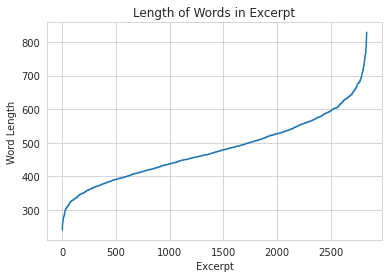

In [ ]:
xs=[]
ys=[]
current_item=1
for item in text:
 xs.append(current_item)
 current_item=current_item+1
 ys.append(len(item))
newys = sorted(ys)
plt.xlabel('Excerpt')
plt.ylabel('Word Length')
plt.title('Length of Words in Excerpt')
plt.plot(xs,newys)

plt.show()

In [ ]:
# Create model with Embedding

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error',optimizer='adam', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            3266432   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 3,268,017
Trainable params: 3,268,017
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 100
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
80/80 [==============================] - 3s 33ms/step - loss: 1.7929 - root_mean_squared_error: 1.2371 - val_loss: 1.3707 - val_root_mean_squared_error: 1.0813
Epoch 2/100
80/80 [==============================] - 2s 31ms/step - loss: 1.0053 - root_mean_squared_error: 0.9135 - val_loss: 0.9478 - val_root_mean_squared_error: 0.8958
Epoch 3/100
80/80 [==============================] - 3s 32ms/step - loss: 0.6483 - root_mean_squared_error: 0.7170 - val_loss: 0.8019 - val_root_mean_squared_error: 0.8215
Epoch 4/100
80/80 [==============================] - 2s 30ms/step - loss: 0.4498 - root_mean_squared_error: 0.5745 - val_loss: 0.7558 - val_root_mean_squared_error: 0.8044
Epoch 5/100
80/80 [==============================] - 2s 31ms/step - loss: 0.3266 - root_mean_squared_error: 0.4701 - val_loss: 0.7473 - val_root_mean_squared_error: 0.8033
Epoch 6/100
80/80 [==============================] - 2s 31ms/step - loss: 0.2484 - root_mean_squared_error: 0.3910 - val_loss: 0.7583 - val_

  hope lay jack promise bright light burning upper story guide course  clear night light visible village  failed account state weather  air eddying flakes  render headlight locomotive invisible yards distant  strange important fact occurred fully fourth mile village   looking vain beacon light  danger situation struck  halted  
  certain wrong   said  
  power follow direct course serve compass  village wait till morning  
[-1.2793456]


  dotty continued mrs  gray night milk  katie went  paused acorn  tree played  king queen   dotty said wished remember bring nipperkins  case milk taste great deal like nectar   nipperkins  pair handled cups children supposed silver  table  
 dotty knew wrong time played  king queen   knew milk  mrs  gray  said   ruthie need measure  pressed run  queenie drink great deal  quart left  yes  know   
 mrs  gray said milk  merely poured pan  gave pail dotty  asking time questions child stay hear 
[-0.24161443]


  bright cheerful scene greeted eyes captain 

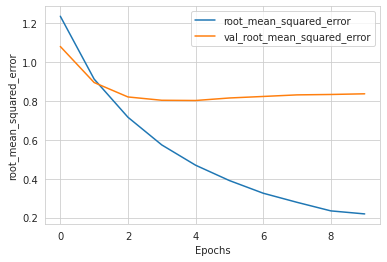

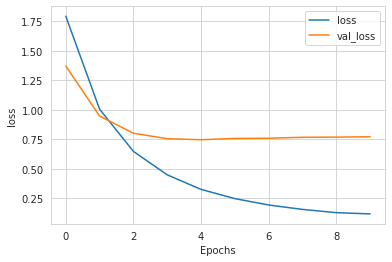

In [ ]:
predict_complexity(model, test_data['excerpt_clean'])
plot_graphs(history, "root_mean_squared_error")
plot_graphs(history, "loss")

### Convolution Neural Networks

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(embedding_dim, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(), 
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            3266432   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 64)            20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 3,288,561
Trainable params: 3,288,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 100
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
80/80 [==============================] - 31s 35ms/step - loss: 2.2381 - root_mean_squared_error: 1.3800 - val_loss: 2.1815 - val_root_mean_squared_error: 1.3621
Epoch 2/100
80/80 [==============================] - 3s 32ms/step - loss: 1.9427 - root_mean_squared_error: 1.2741 - val_loss: 1.9162 - val_root_mean_squared_error: 1.2662
Epoch 3/100
80/80 [==============================] - 3s 32ms/step - loss: 1.6452 - root_mean_squared_error: 1.1566 - val_loss: 1.6345 - val_root_mean_squared_error: 1.1543
Epoch 4/100
80/80 [==============================] - 3s 32ms/step - loss: 1.3928 - root_mean_squared_error: 1.0469 - val_loss: 1.4925 - val_root_mean_squared_error: 1.0961
Epoch 5/100
80/80 [==============================] - 3s 32ms/step - loss: 1.2597 - root_mean_squared_error: 0.9870 - val_loss: 1.4248 - val_root_mean_squared_error: 1.0701
Epoch 6/100
80/80 [==============================] - 2s 31ms/step - loss: 1.1756 - root_mean_squared_error: 0.9496 - val_loss: 1.3795 - val

In [ ]:
model.save("commonlitmodel.h5")

### Gated Recurrent Units

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

In [ ]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

### Simple Bi-derectional Long Short Term Memory

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

In [ ]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

### Multiple Bi-derectional Long Short Term Memory

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

In [ ]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

## Hyper Parameters Tuning

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=16, max_value=256, step=8)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=[RootMeanSquaredError()])

  return model

### Random Search

In [ ]:
tuner_search=kt.RandomSearch(model_builder,
                       objective = kt.Objective("val_root_mean_squared_error", direction="min"),
                       max_trials=5,directory='output',project_name="nlp")


### Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     max_epochs=10,
                     objective = kt.Objective("val_root_mean_squared_error", direction="min"),
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

## Glove Embeddings

In [ ]:
glove_embeddings = dict()
f = open('/kaggle/input/glove6b/glove.6B.50d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 glove_embeddings[word] = coefs
f.close()

In [ ]:
glove_embeddings['frog']

In [ ]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(glove_embeddings[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(50)
    return v / np.sqrt((v ** 2).sum())

### Extreme Gradient Boosting

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_train.excerpt_clean, df_train.target, 
 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [ ]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in xtrain]
xvalid_glove = [sent2vec(x) for x in xvalid]

In [ ]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [ ]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBRegressor(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict(xvalid_glove)

print ("MSE: %f " % mse(yvalid, predictions))

### Stacked LSTM

In [ ]:
embedding_dim = 50
vocab_size = 51308

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
 if index > vocab_size - 1:
     break
 else:
     embedding_vector = glove_embeddings.get(word)
 if embedding_vector is not None:
     embedding_matrix[index] = embedding_vector

In [ ]:
model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
 return_sequences=True)),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
 tf.keras.layers.Dense(24, activation='relu'),
 tf.keras.layers.Dense(1)
])

In [ ]:
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

In [ ]:
num_epochs = 100
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.3,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

In [ ]:
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
 xs.append(index)
 cumulative_x.append(index)
 if glove_embeddings.get(word) is not None:
     total_y = total_y + 1
     ys.append(1)
 else:
     ys.append(0)
 cumulative_y.append(total_y / index)

In [ ]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)
plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)

In [ ]:
plt.plot(cumulative_x, cumulative_y)
plt.axis([0, 25000, .915, .985])


## BERT HuggingFace Transformer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [ ]:
def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.excerpt)):
      encoded = tokenizer.encode_plus(
        
        data.excerpt[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)


In [ ]:
train_input_ids,train_attention_masks = bert_encode(df_train,60)
test_input_ids,test_attention_masks = bert_encode(df_test,60)

In [ ]:
def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  #output = tf.keras.layers.Dense(32,activation='relu')(output)
  #output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1)(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(tf.keras.optimizers.Adam(lr=6e-6), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
  return model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

In [ ]:
model = create_model(bert_model)
model.summary()

In [ ]:
history = model.fit([train_input_ids,train_attention_masks],df_train.target,validation_split=0.3, epochs=2,batch_size=10)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## RoBerta HuggingFace Transformer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
BASE_MODEL = TFRobertaModel.from_pretrained('roberta-base')

In [ ]:
def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1)(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  
  return model



model = create_model(BASE_MODEL)
model.compile(tf.keras.optimizers.Adam(lr=6e-6), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    
model.summary()

In [ ]:
history = model.fit([train_input_ids,train_attention_masks],df_train.target,validation_split=0.3, epochs=2,batch_size=10)